In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from pandas.plotting import table
from sklearn import preprocessing
import pylab as pl
import statistics 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
#from pandas import table
import pickle

## Import dataset

In [2]:
df = pd.read_pickle("Data\Final.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1123 entries, 21888626 to 3671486
Data columns (total 40 columns):
accuracyRating           1123 non-null float64
allowsChildren           1123 non-null uint8
allowsEvents             1123 non-null uint8
allowsInfants            1123 non-null uint8
allowsPets               1123 non-null uint8
allowsSmoking            1123 non-null uint8
bathrooms                1123 non-null float64
bedrooms                 1123 non-null float64
beds                     1123 non-null float64
checkinRating            1123 non-null float64
cleanlinessRating        1123 non-null float64
communicationRating      1123 non-null float64
isBusinessTravel         1123 non-null uint8
isFullyRefundable        1123 non-null uint8
isHotel                  1123 non-null uint8
isInstantBookPossible    1123 non-null uint8
isSuperHost              1123 non-null uint8
isVerified               1123 non-null uint8
location                 1123 non-null category
locationRating  

# 1) Objective and Y definition (dependent variable)

- Objective: Search for the variables that influence the ratePerNight
<br>
- Definir o Y:
For the dependent variable, there were two option: totalPrice or ratePerNight. 
The dependent variable chose was ratePerNight because it can be compared and predicted for a different period of days. It reflects better the house/ apart "value".

In order to validate that ratePerNight was the same as totalPrice divide by 5 days (and that both not include the serviceFee), we test it: 

In [3]:
alfa = df["totalPrice"].apply(lambda x : x/5)
beta = df["ratePerNight"]
diff = alfa - beta
diff.describe()

count    1123.000000
mean       -0.402137
std         0.286964
min        -0.800000
25%        -0.600000
50%        -0.400000
75%        -0.200000
max         0.000000
dtype: float64

Conclusion: the difference between these two variables is just some cents. In case of a Diff greater than 0.8 € it is removed

In [4]:
df.drop(['totalPrice'], axis=1, inplace=True)

In [5]:
row = len(df)
print("Nr of rooms/houses before correction of price is", row)  

Nr of rooms/houses before correction of price is 1123


In [6]:
df.loc[:,'diff'] = diff
df = pd.DataFrame(df.loc[abs(df["diff"])<0.8])

row1 = len(df)
print("Nr of rooms/houses after correction of price is", row1) 

Nr of rooms/houses after correction of price is 1080


- Eliminate Diff column 

In [7]:
df.drop(['diff'], axis=1, inplace=True)

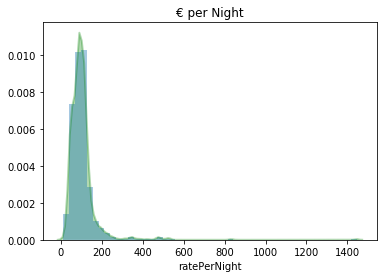

In [8]:
# Dependent variable description (ratePerNight)
sns.distplot(df['ratePerNight'],
           kde=True,
            kde_kws={"color":"g", "alpha":0.3,"linewidth":2, "shade": True},
           hist=True).set_title("€ per Night")
plt.savefig('ydist.png')
plt.show() # colocar linha

## 2) Data Preprocessing

### 2.1) Cleaning Data

#### Eliminate variables that are not relevant for the analysis: url, minNights, reviews. Reviews are going to be treated later.

In [9]:
list_drop = ['url', 'minNights', 'reviews']
df.drop(list_drop, axis=1, inplace=True)

### 2.2) Numerical variables caracterization - Histograms

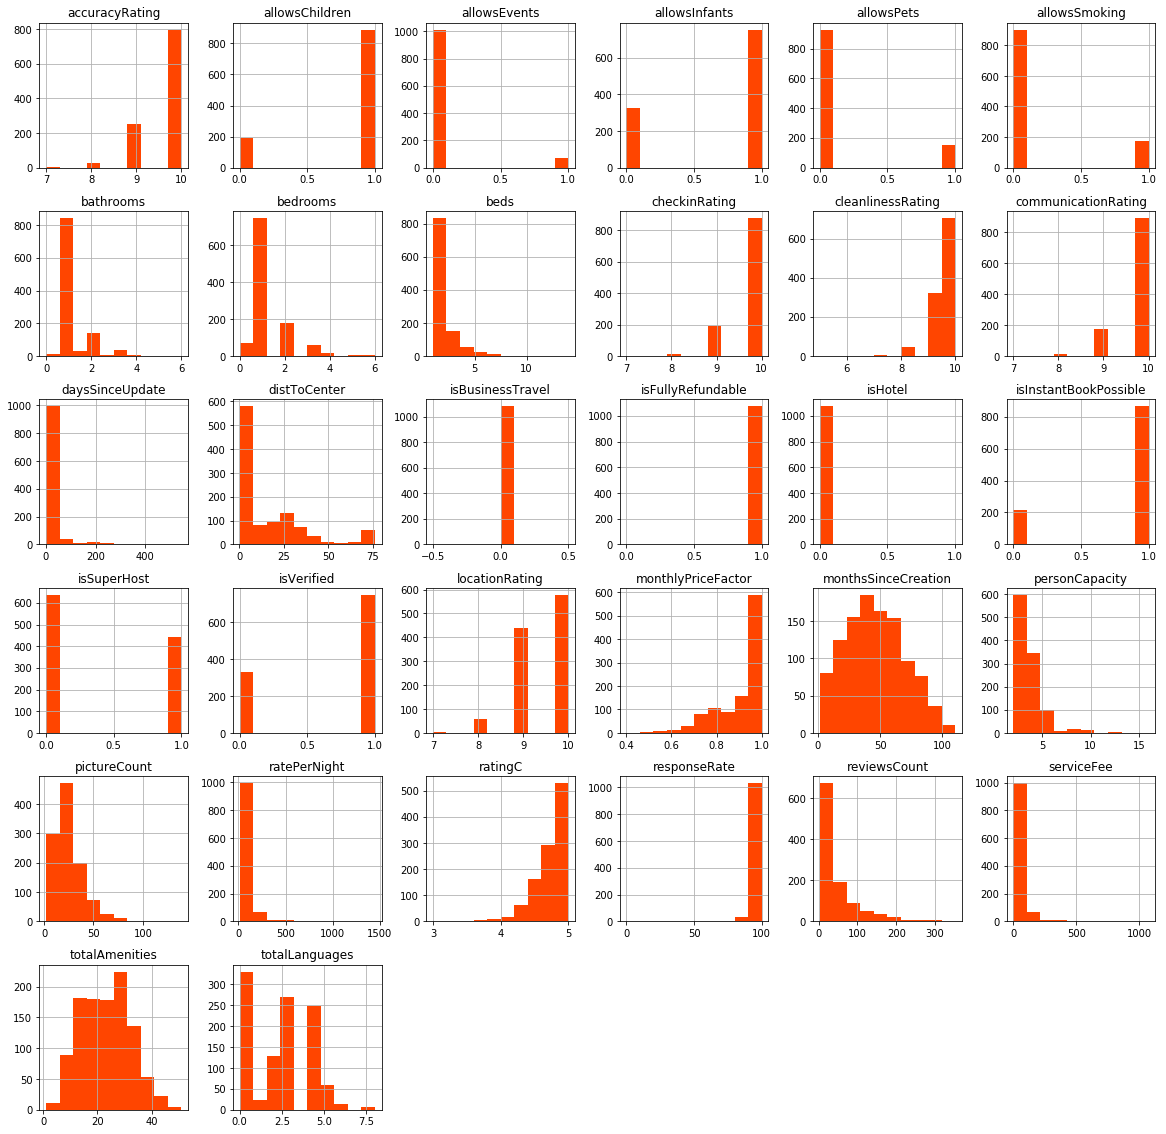

In [10]:
#analise estatistica dos dados
df.hist(figsize=(20,20), color="OrangeRed")
plt.savefig('NumericalHist.png')
plt.show()

### 2.3) Categorical variables caracterization - histograms

#### Categorical variables are: 
- location; 
- rating;
- responseTime;
- roomType.

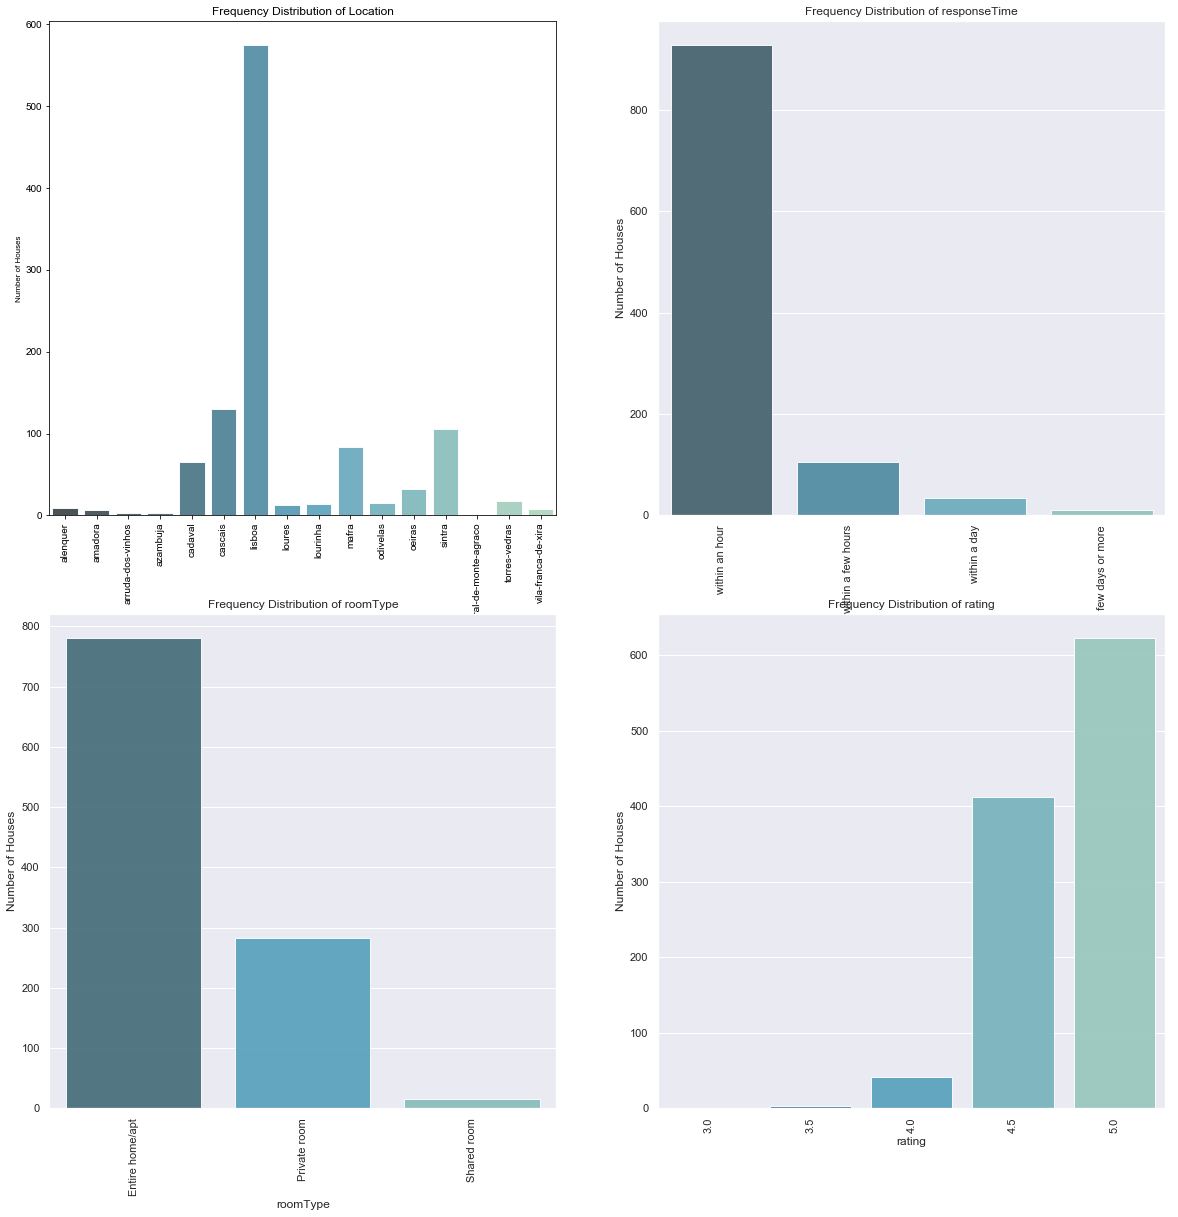

In [11]:
fig = plt.figure(figsize = (20,20))
gs = GridSpec(2, 2, figure=fig)

a = fig.add_subplot(gs[0, 0])
id_count = df['location'].value_counts()
sns.set(style="darkgrid")
a = sns.barplot(id_count.index, id_count.values, alpha=0.9, palette='GnBu_d')
plt.title('Frequency Distribution of Location')
plt.ylabel('Number of Houses', fontsize=8)
plt.xlabel('Location', fontsize=8)
for item in a.get_xticklabels():
    item.set_rotation(90)

b = fig.add_subplot(gs[-1, 0])
id_count = df['roomType'].value_counts()
sns.set(style="darkgrid")
a = sns.barplot(id_count.index, id_count.values, alpha=0.9, palette='GnBu_d')
plt.title('Frequency Distribution of roomType')
plt.ylabel('Number of Houses', fontsize=12)
plt.xlabel('roomType', fontsize=12)
for item in a.get_xticklabels():
    item.set_rotation(90)
    
    
c = fig.add_subplot(gs[0, 1])
id_count = df['responseTime'].value_counts()
sns.set(style="darkgrid")
a = sns.barplot(id_count.index, id_count.values, alpha=0.9, palette='GnBu_d')
plt.title('Frequency Distribution of responseTime')
plt.ylabel('Number of Houses', fontsize=12)
plt.xlabel('responseTime', fontsize=12)
for item in a.get_xticklabels():
    item.set_rotation(90)
    
    
d = fig.add_subplot(gs[-1, -1])
id_count = df['rating'].value_counts()
sns.set(style="darkgrid")
a = sns.barplot(id_count.index, id_count.values, alpha=0.9, palette='GnBu_d')
plt.title('Frequency Distribution of rating')
plt.ylabel('Number of Houses', fontsize=12)
plt.xlabel('rating', fontsize=12)
for item in a.get_xticklabels():
    item.set_rotation(90)
plt.savefig('CategoricalHist.png')
plt.show()

### 2.4) How to select the right variables to the model? - Feature selection model

### __Feature Selection__
<br>
What is Feature Selection?
<br>
<br>
Feature selection is also called variable selection or attribute selection.
It is the automatic selection of attributes in your data (such as columns in tabular data) that are most relevant to the predictive modeling problem you are working on.
<br>
Feature selection methods aid you in your mission to create an accurate predictive model. They help you by choosing features that will give you as good or better accuracy whilst requiring less data.
Feature selection methods can be used to identify and remove unneeded, irrelevant and redundant attributes from data that do not contribute to the accuracy of a predictive model or may in fact decrease the accuracy of the model.
<br>
<br>
https://machinelearningmastery.com/an-introduction-to-feature-selection/
<br>
<br>
There were test three types of feature selection methods:
<br>

- Filter Methods
<br>
- Wrapper Methods
<br>
- Embeded Methods

### __Que variaveis são mais importantes para explicar o ratePerNight?__
<br>
- 1ª Fomos testar as variaveis numéricas

In [12]:
numerics = ["float64","int32","int64","uint8"]
df_n=df.select_dtypes(include=numerics)

- Definir o nosso y e as nossas variáveis explicativas (X)

In [13]:
data = df_n
X= df_n.drop(["ratePerNight"], axis=1)  #independent column
y= df_n[["ratePerNight"]]  #target column i.e price range

In [14]:
## to transform Y to an array of 1 dimension
y1 = y.values.transpose()
y2 = np.concatenate(y1)

#### 2.4.1) __Filter Methods__

Filter feature selection methods apply a statistical measure to assign a scoring to each feature. The features are ranked by the score and either selected to be kept or removed from the dataset. The methods are often univariate and consider the feature independently, or with regard to the dependent variable.


- __SelectKBest__ A filter Method. The null hypothesis for chi2 test is that "two categorical variables are independent". So a higher value of chi2 statistic means "two categorical variables are dependent" and thus more usefull. In our case, we have performed a chi2test that would give us the top10 features, based on higher chi2 values. 

In [15]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 

chi_support = bestfeatures.get_support()

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))

                  Specs         Score
25           serviceFee  45066.068726
28      daysSinceUpdate  24005.145549
24         reviewsCount  13001.595073
26         distToCenter   6164.559827
21         pictureCount   2834.633438
27  monthsSinceCreation   2185.909445
29       totalAmenities    975.681623
8                  beds    467.438563
20       personCapacity    436.487315
30       totalLanguages    295.338488


In [16]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit_transform(X,y)
print('Original number of features:', X.shape[1])
print('Reduced number of features:', fit.shape[1])

Original number of features: 31
Reduced number of features: 10


#### 2.4.2) __Wrapper Methods__
Wrapper methods consider the selection of a set of features as a search problem, where different combinations are prepared, evaluated and compared to other combinations. A predictive model us used to evaluate a combination of features and assign a score based on model accuracy.

The search process may be methodical such as a best-first search, it may stochastic such as a random hill-climbing algorithm, or it may use heuristics, like forward and backward passes to add and remove features.

- __RFE__ Wrapper Model

In [17]:
rfe_selector = RFE(estimator=LogisticRegression(solver='saga',multi_class='auto'), n_features_to_select=10, step=1, verbose=5)
rfe_selector.fit(X, y2)

Fitting estimator with 31 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 30 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 29 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 28 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 27 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 26 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 25 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 24 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 23 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 22 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 21 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 20 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 19 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 18 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 17 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 16 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 15 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 14 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 13 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 12 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Fitting estimator with 11 features.


c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=None, solver='saga', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=10, step=1, verbose=5)

__Conclusion:__ It is possible that our data can not be fitted by a logistics model.

#### 2.4.3) __Embedded Methods__
Embedded methods learn which features best contribute to the accuracy of the model while the model is being created. The most common type of embedded feature selection methods are regularization methods.

Regularization methods are also called penalization methods that introduce additional constraints into the optimization of a predictive algorithm (such as a regression algorithm) that bias the model toward lower complexity (fewer coefficients).

- __Random Forest__ Embedded Method

In [18]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=10), threshold='1.25*median')
embeded_rf_selector.fit(X, y2)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=10, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
   

In [19]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

12 selected features


- __Tree Decision__

[0.02143641 0.01234206 0.00610287 0.02014403 0.01667459 0.017248
 0.02865549 0.02813403 0.03733039 0.01466653 0.02391712 0.0175095
 0.         0.00165458 0.00206188 0.02064294 0.02121473 0.02073175
 0.02958346 0.04986346 0.03847585 0.05992387 0.05595621 0.01970889
 0.05846623 0.09265399 0.06853198 0.05703185 0.05099094 0.06180435
 0.04654199]


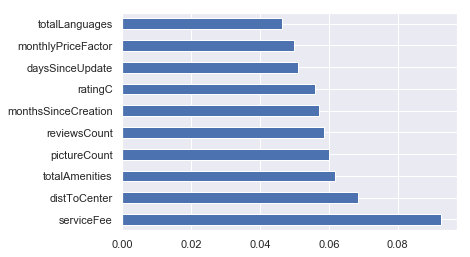

In [20]:
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X,y2)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

plt.show()

In [21]:
# Classification with True the top 10 variables:
feat_importances_s = feat_importances >= float(feat_importances.nlargest(10).nsmallest(1))
feat_importances_s1 = pd.DataFrame(feat_importances_s)
feat_importances_s2 = feat_importances_s1.values.transpose()
feat_importances_support = np.concatenate(feat_importances_s2)

#### __Summary__

In [22]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':X.columns.tolist(), 'Chi-2':chi_support, 
                                     'Random Forest':embeded_rf_support,
                                    'Tree Classifier' : feat_importances_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 10
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(10)

,Feature,Chi-2,Random Forest,Tree Classifier,Total
1,totalLanguages,True,True,True,3
2,totalAmenities,True,True,True,3
3,serviceFee,True,True,True,3
4,reviewsCount,True,True,True,3
5,pictureCount,True,True,True,3
6,monthsSinceCreation,True,True,True,3
7,distToCenter,True,True,True,3
8,daysSinceUpdate,True,True,True,3
9,ratingC,False,True,True,2
10,personCapacity,True,True,False,2


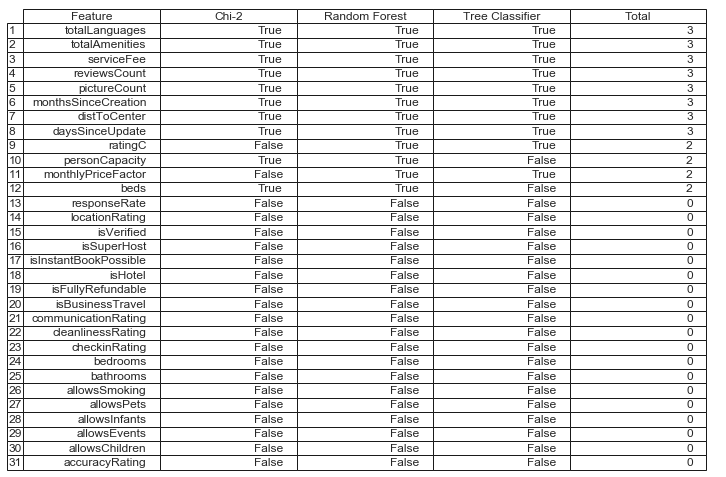

In [23]:
fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, feature_selection_df, loc='upper right', colWidths=[0.17]*len(feature_selection_df.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table
plt.savefig('Featurestable.png', transparent=True)

### __Multicolinearity__

In [24]:
list10 = feature_selection_df["Feature"].head(8)
top10 = df_n.loc[:,list10]

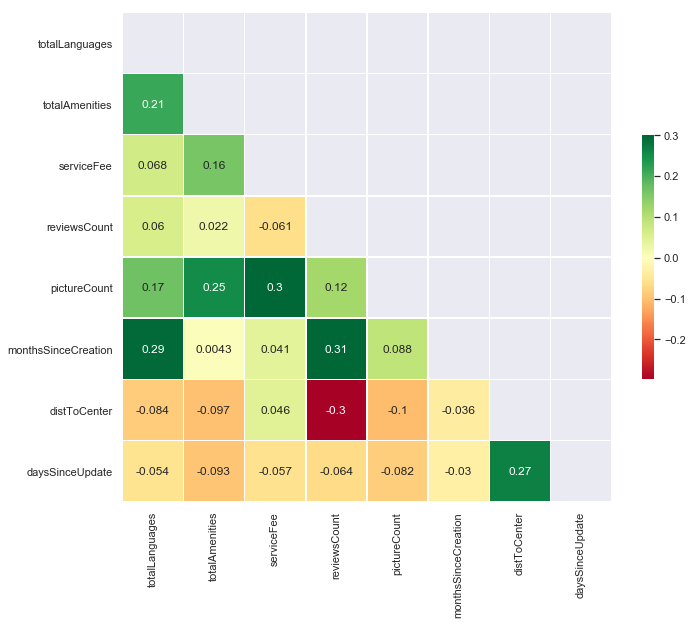

In [25]:
#get correlations of each features in dataset
corr = top10.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, cmap="RdYlGn", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig("correlmatrix.png")

# CONCLUSOES DA CORREL MATRIX 

## 2.5) Remove Outliers

In [26]:
df_out = top10 
df_out['responseTime'] = df['responseTime']
df_out['roomType'] = df['roomType']
df_out['location'] = df['location']
df_out['ratePerNight'] = df['ratePerNight']
df_out.head()

,totalLanguages,totalAmenities,serviceFee,reviewsCount,pictureCount,monthsSinceCreation,distToCenter,daysSinceUpdate,responseTime,roomType,location,ratePerNight
id,,,,,,,,,,,,
21888626,0,10,56.0,7,29,18.833333,43.209876,544.0,within an hour,Entire home/apt,alenquer,82.0
23720498,5,15,63.0,5,12,53.333333,45.932316,3.0,within an hour,Entire home/apt,alenquer,93.0
22981563,1,17,39.0,3,28,16.800000,45.391489,25.0,within an hour,Entire home/apt,alenquer,57.0
5371649,0,14,29.0,31,37,62.500000,41.607718,3.0,within a few hours,Entire home/apt,alenquer,42.0
18837008,4,15,67.0,3,26,24.966667,50.172070,11.0,within a few hours,Entire home/apt,alenquer,99.0


In [27]:
le = preprocessing.LabelEncoder()
le.fit(df_out['responseTime'])
df_out['respTime']=le.transform(df_out['responseTime']) 

In [28]:
le.fit(df_out['roomType'])
df_out['room']=le.transform(df_out['roomType']) 

In [29]:
le.fit(df_out['location'])
df_out['loc']=le.transform(df_out['location'])

In [30]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1080 entries, 21888626 to 3671486
Data columns (total 15 columns):
totalLanguages         1080 non-null int32
totalAmenities         1080 non-null int32
serviceFee             1080 non-null float64
reviewsCount           1080 non-null int32
pictureCount           1080 non-null int32
monthsSinceCreation    1080 non-null float64
distToCenter           1080 non-null float64
daysSinceUpdate        1080 non-null float64
responseTime           1080 non-null category
roomType               1080 non-null category
location               1080 non-null category
ratePerNight           1080 non-null float64
respTime               1080 non-null int32
room                   1080 non-null int32
loc                    1080 non-null int32
dtypes: category(3), float64(5), int32(7)
memory usage: 79.7+ KB


In [31]:
X = df_out.drop(['responseTime','roomType','location','ratePerNight'], axis=1)

- Definition of the clusters number

In [32]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(X)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

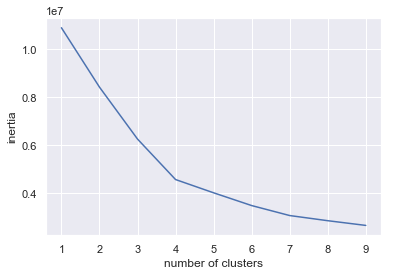

In [33]:
# Plot ks (x-axis) vs inertias (y-axis) using plt.plot(). 
plt.plot(ks, inertias)

# define the label for x axis as 'number of clusters' using matplotlib.pyplot.xlabel
plt.xlabel('number of clusters')
# define the label for y axis as 'inertia' using matplotlib.pyplot.ylabel
plt.ylabel('inertia')
# define the ticks in x axis using the values of ks
plt.xticks(ks)
# call plt.show()
plt.savefig("KMeans.png")
plt.show()

#### The clusters number is 4, because after that the curve slope decreases 

In [34]:
model = KMeans(n_clusters=4 )
model.fit(X)
X['label'] = model.labels_

In [35]:
descr = X.groupby(['label']).describe().transpose()
descr

label                               0           1           2            3
totalLanguages      count  863.000000  159.000000   41.000000    17.000000
                    mean     2.316338    2.484277    1.951220     2.294118
                    std      1.838818    1.487736    1.856761     1.829095
                    min      0.000000    0.000000    0.000000     0.000000
                    25%      0.000000    2.000000    0.000000     0.000000
                    50%      3.000000    3.000000    2.000000     3.000000
                    75%      4.000000    4.000000    4.000000     4.000000
                    max      8.000000    5.000000    6.000000     5.000000
totalAmenities      count  863.000000  159.000000   41.000000    17.000000
                    mean    22.792584   21.937107   19.341463    26.823529
                    std      8.940372    8.679735   10.586807    10.387705
                    min      2.000000    5.000000    1.000000    14.000000
                    25%     15.000000   15.000000   10.000000    18.000000
                    50%     23.000000   22.000000   20.000000    25.000000
                    75%     29.000000   28.000000   27.000000    33.000000
                    max     51.000000   45.000000   39.000000    45.000000
serviceFee          count  863.000000  159.000000   41.000000    17.000000
                    mean    66.239861   64.301887   62.000000   383.352941
                    std     29.465804   24.065510   44.873155   198.343118
                    min      0.000000    0.000000   21.000000   247.000000
                    25%     47.000000   52.500000   40.000000   279.000000
                    50%     65.000000   63.000000   48.000000   345.000000
                    75%     80.000000   76.000000   66.000000   384.000000
                    max    210.000000  217.000000  262.000000  1074.000000
reviewsCount        count  863.000000  159.000000   41.000000    17.000000
                    mean    27.395133  158.559748   20.512195    18.176471
                    std     23.310281   59.707790   39.311018    22.029058
                    min      3.000000   91.000000    3.000000     3.000000
                    25%      8.000000  113.500000    5.000000     7.000000
                    50%     20.000000  144.000000    9.000000    10.000000
                    75%     41.000000  185.500000   21.000000    23.000000
                    max     96.000000  352.000000  250.000000    91.000000
pictureCount        count  863.000000  159.000000   41.000000    17.000000
                    mean    24.389340   26.899371   18.707317    43.235294
                    std     14.621964   12.322253    9.968059    19.565689
                    min      2.000000    5.000000    3.000000     7.000000
                    25%     15.000000   18.000000   10.000000    30.000000
                    50%     21.000000   25.000000   15.000000    44.000000
                    75%     31.000000   36.000000   28.000000    51.000000
                    max    139.000000   61.000000   42.000000    91.000000
monthsSinceCreation count  863.000000  159.000000   41.000000    17.000000
                    mean    43.648783   60.750314   40.861789    42.613725
                    std     23.324659   19.857501   22.681247    22.629139
                    min      1.633333   10.766667   10.766667     8.700000
                    25%     24.966667   45.233333   23.933333    24.966667
                    50%     40.133333   58.433333   38.133333    45.233333
                    75%     60.466667   76.633333   49.333333    60.466667
                    max    108.166667  110.200000   99.033333    77.666667
distToCenter        count  863.000000  159.000000   41.000000    17.000000
                    mean    16.802246    4.993258   42.884117    27.970654
                    std     19.710894    8.364612   25.122595     7.732334
                    min      0.066077    0.122017    0.893418    17.545080
                    25%  

In [36]:
df_out['clusters'] = X['label']
df_out.drop(['responseTime','roomType','location'], axis=1, inplace=True)

In [37]:
cluster0 = df_out[df_out.clusters==0]
cluster1 = df_out[df_out.clusters==1]
cluster2 = df_out[df_out.clusters==2]
cluster3 = df_out[df_out.clusters==3]

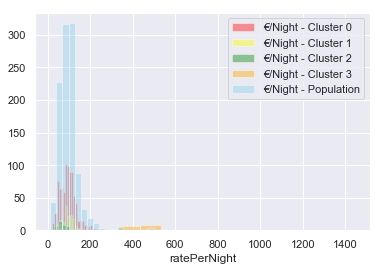

In [38]:
sns.distplot(cluster0['ratePerNight'],color='red',label='€/Night - Cluster 0', kde = False)
sns.distplot(cluster1['ratePerNight'],color='yellow',label='€/Night - Cluster 1', kde = False)
sns.distplot(cluster2['ratePerNight'],color='green',label='€/Night - Cluster 2', kde = False)
sns.distplot(cluster3['ratePerNight'],color='orange',label='€/Night - Cluster 3', kde = False)
sns.distplot(df_out['ratePerNight'],color='skyblue',label='€/Night - Population', kde = False)
plt.legend()
plt.savefig("ClustersDist.png")

In [39]:
cluster0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 863 entries, 23720498 to 11790067
Data columns (total 13 columns):
totalLanguages         863 non-null int32
totalAmenities         863 non-null int32
serviceFee             863 non-null float64
reviewsCount           863 non-null int32
pictureCount           863 non-null int32
monthsSinceCreation    863 non-null float64
distToCenter           863 non-null float64
daysSinceUpdate        863 non-null float64
ratePerNight           863 non-null float64
respTime               863 non-null int32
room                   863 non-null int32
loc                    863 non-null int32
clusters               863 non-null int32
dtypes: float64(5), int32(8)
memory usage: 64.1+ KB


In [40]:
mean0 = cluster0['ratePerNight'].mean()
sd0 = statistics.stdev(cluster0['ratePerNight'])

mean1 = cluster1['ratePerNight'].mean()
sd1 = statistics.stdev(cluster1['ratePerNight'])

mean2 = cluster2['ratePerNight'].mean()
sd2 = statistics.stdev(cluster2['ratePerNight'])

mean3 = cluster3['ratePerNight'].mean()
sd3 = statistics.stdev(cluster3['ratePerNight'])

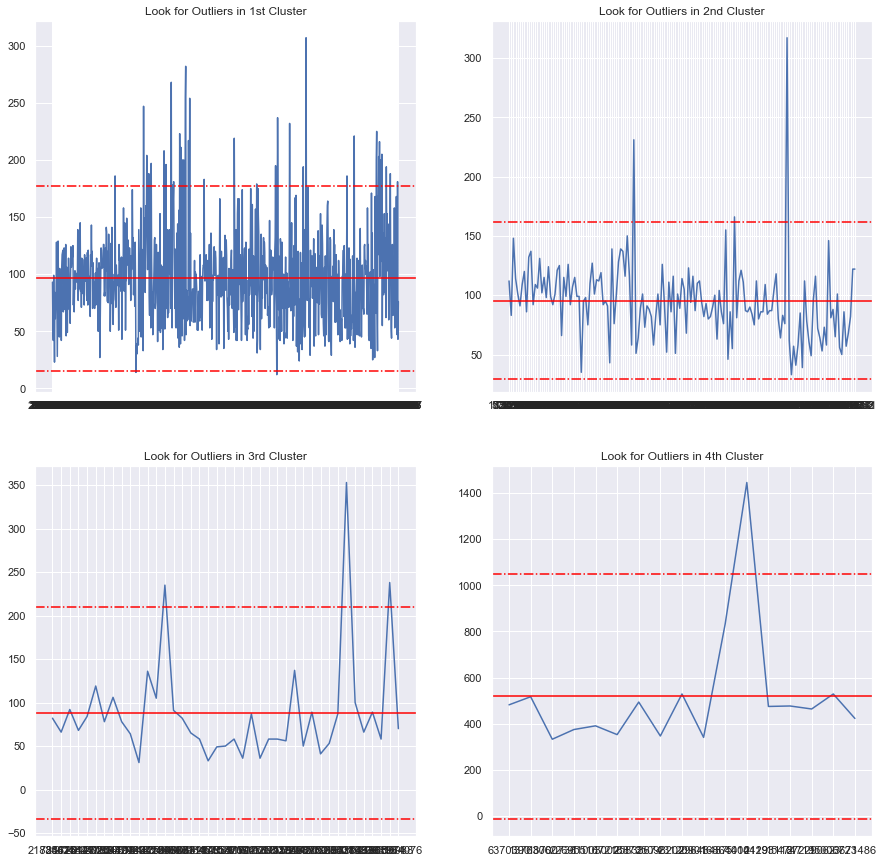

In [41]:
fig = plt.figure(figsize = (15,15))
gs = GridSpec(2, 2, figure=fig)

a = fig.add_subplot(gs[0, 0])
a = plt.plot(cluster0['ratePerNight'])
pl.axhline(y= mean0, color="red")
pl.axhline(mean0+2*sd0, color="red", linestyle='-.')
pl.axhline(mean0-2*sd0, color="red", linestyle='-.')
plt.title('Look for Outliers in 1st Cluster')


b = fig.add_subplot(gs[0, -1])
b = plt.plot(cluster1['ratePerNight'])
pl.axhline(y= mean1, color="red")
pl.axhline(mean1+2*sd1, color="red", linestyle='-.')
pl.axhline(mean1-2*sd1, color="red", linestyle='-.')
plt.title('Look for Outliers in 2nd Cluster')

c = fig.add_subplot(gs[-1, 0])
c = plt.plot(cluster2['ratePerNight'])
pl.axhline(y= mean2, color="red")
pl.axhline(mean2+2*sd2, color="red", linestyle='-.')
pl.axhline(mean2-2*sd2, color="red", linestyle='-.')
plt.title('Look for Outliers in 3rd Cluster')

d = fig.add_subplot(gs[-1, -1])
d = plt.plot(cluster3['ratePerNight'])
pl.axhline(y= mean3, color="red")
pl.axhline(mean3+2*sd3, color="red", linestyle='-.')
pl.axhline(mean3-2*sd3, color="red", linestyle='-.')
plt.title('Look for Outliers in 4th Cluster')

plt.savefig("Outliers.png")
plt.show()

## Retirar Outliers

__Outliers__ = every data.point outside the range mean +- 2*standard deviation

In [42]:
a = df_out[(df_out['clusters'] == 0)]
b = a[(a['ratePerNight'] < mean0+2*sd0)]
c = b[(b['ratePerNight'] > mean0-2*sd0)]

e = df_out[(df_out['clusters'] == 1)]
f = e[(e['ratePerNight'] < mean1+2*sd1)]
g = f[(f['ratePerNight'] > mean1-2*sd1)]

h = df_out[(df_out['clusters'] == 2)]
i = h[(h['ratePerNight'] < mean2+2*sd2)]
j = i[(i['ratePerNight'] > mean2-2*sd2)]

k = df_out[(df_out['clusters'] == 3)]
l = k[(k['ratePerNight'] < mean3+2*sd3)]
m = l[(l['ratePerNight'] > mean3-2*sd3)]

df_o1 = c.append([g,j,m])

In [43]:
df_o1_0 = df_o1[df_o1.clusters==0]
df_o1_1 = df_o1[df_o1.clusters==1]
df_o1_2 = df_o1[df_o1.clusters==2]
df_o1_3 = df_o1[df_o1.clusters==3]

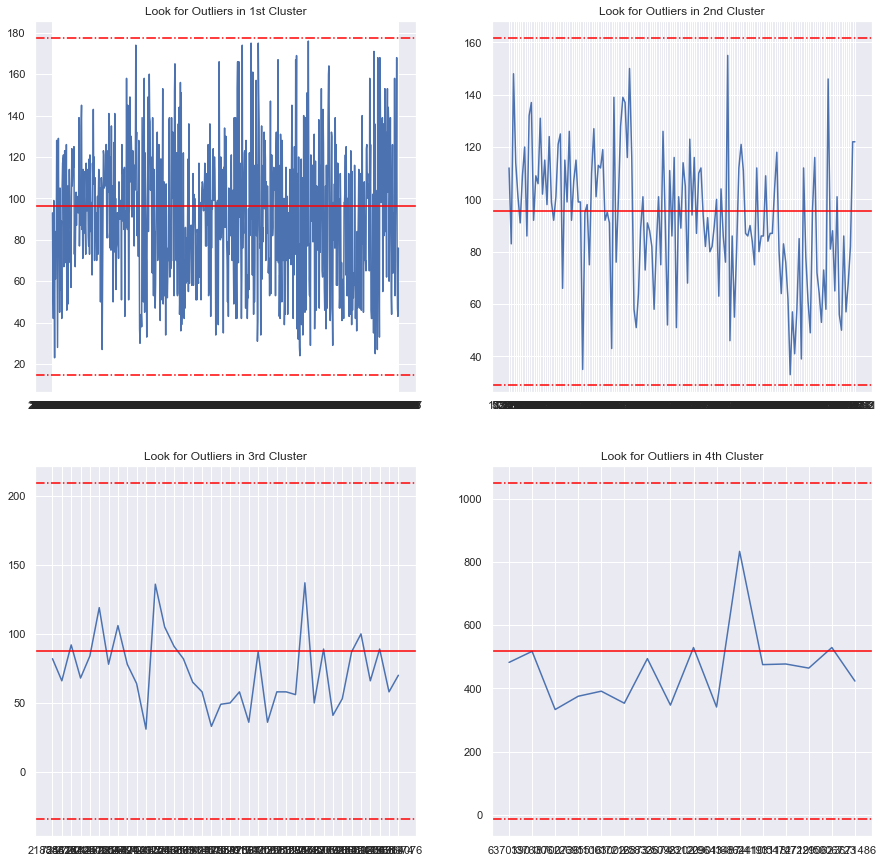

In [44]:
fig = plt.figure(figsize = (15,15))
gs = GridSpec(2, 2, figure=fig)

a = fig.add_subplot(gs[0, 0])
a = plt.plot(df_o1_0['ratePerNight'])
pl.axhline(y= mean0, color="red")
pl.axhline(mean0+2*sd0, color="red", linestyle='-.')
pl.axhline(mean0-2*sd0, color="red", linestyle='-.')
plt.title('Look for Outliers in 1st Cluster')

b = fig.add_subplot(gs[0, -1])
b = plt.plot(df_o1_1['ratePerNight'])
pl.axhline(y= mean1, color="red")
pl.axhline(mean1+2*sd1, color="red", linestyle='-.')
pl.axhline(mean1-2*sd1, color="red", linestyle='-.')
plt.title('Look for Outliers in 2nd Cluster')

c = fig.add_subplot(gs[-1, 0])
c = plt.plot(df_o1_2['ratePerNight'])
pl.axhline(y= mean2, color="red")
pl.axhline(mean2+2*sd2, color="red", linestyle='-.')
pl.axhline(mean2-2*sd2, color="red", linestyle='-.')
plt.title('Look for Outliers in 3rd Cluster')

d = fig.add_subplot(gs[-1, -1])
d = plt.plot(df_o1_3['ratePerNight'])
pl.axhline(y= mean3, color="red")
pl.axhline(mean3+2*sd3, color="red", linestyle='-.')
pl.axhline(mean3-2*sd3, color="red", linestyle='-.')
plt.title('Look for Outliers in 4th Cluster')

plt.savefig("NoOutliers.png")
plt.show()

### Final Dataset:

In [45]:
dfinal = df_o1.copy()

In [46]:
dfinal.describe()

,totalLanguages,totalAmenities,serviceFee,reviewsCount,pictureCount,monthsSinceCreation,distToCenter,daysSinceUpdate,ratePerNight,respTime,room,loc,clusters
count,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000
mean,2.303001,22.355276,66.505324,47.249758,24.442401,46.120523,15.922386,21.264279,96.378509,2.810261,0.302033,6.925460,0.271055
std,1.782277,8.877538,42.464785,57.171963,14.211198,23.773703,19.994770,51.359397,57.080531,0.525338,0.489983,2.625394,0.603691
min,0.000000,1.000000,0.000000,3.000000,2.000000,1.633333,0.066077,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,15.000000,46.000000,9.000000,15.000000,27.000000,1.526660,3.000000,69.000000,3.000000,0.000000,6.000000,0.000000
50%,3.000000,23.000000,63.000000,26.000000,21.000000,44.233333,6.448071,4.000000,92.000000,3.000000,0.000000,6.000000,0.000000
75%,4.000000,29.000000,79.000000,63.000000,31.000000,61.500000,23.929347,15.000000,114.000000,3.000000,1.000000,8.000000,0.000000
max,8.000000,51.000000,619.000000,352.000000,139.000000,110.200000,76.282635,544.000000,833.000000,3.000000,2.000000,15.000000,3.000000


In [47]:
dfinal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 23720498 to 3671486
Data columns (total 13 columns):
totalLanguages         1033 non-null int32
totalAmenities         1033 non-null int32
serviceFee             1033 non-null float64
reviewsCount           1033 non-null int32
pictureCount           1033 non-null int32
monthsSinceCreation    1033 non-null float64
distToCenter           1033 non-null float64
daysSinceUpdate        1033 non-null float64
ratePerNight           1033 non-null float64
respTime               1033 non-null int32
room                   1033 non-null int32
loc                    1033 non-null int32
clusters               1033 non-null int32
dtypes: float64(5), int32(8)
memory usage: 76.7+ KB


## 2.7) Predictive Model

Predictive analytics is the process of discovering interesting and meaningful patterns in data. 
We have used supervised learning methods as we have a target variable, that we wish to predict given our features.

### 2.7.1) Split the dataset into X_train, X_test, y_train and y_test

A train/test split is a method for splitting our dataset into two groups, a training group of data-points that will be used to train the model, and a testing group that will be used to test it

In [48]:
X = dfinal.drop(["ratePerNight", 'clusters'], axis=1)  #independent columns

y_ = dfinal[["ratePerNight"]]  #target column i.e price range
y__ = y_.values.transpose()
y = np.concatenate(y__)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123) #80% training and 20% test; #random_state=some_number guarantees
                                                                      #that the output of Run 1 will be equal to the output of Run 2,


In [49]:
## Confirm that it is 80/20
X_train.shape
X_test.shape
a= X_train.shape[0]/X.shape[0]
print("Training dataset has ", X_train.shape[0]," & Testing dataset has",X_test.shape[0],". Ratio =",X_train.shape[0],"/",X.shape[0]," is ", a,".")

Training dataset has  826  & Testing dataset has 207 . Ratio = 826 / 1033  is  0.7996127783155856 .


### 2.7.2) 3 diferent models:

- _DecisionTree_

Since we have a data set with numerical and categorical variables, we have deciced to use Decision Tree models. Some of the advantages are:
- decision tree algorithms can handle both nominal and continuous inputs;
- easy to understand;
- easily implemented;
- non-parametric, making no assumptions about distributions for inputs or the target variable
- excellent for data exploration with hundreds of variables
-  many decision tree algorithms can handle missing data automatically => though it is not a problem in our data set, since we have already cleaned our data in the pre-processing

In [50]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [51]:
tree_mse = mean_squared_error(y_train, tree_model.predict(X_train))
tree_mae = mean_absolute_error(y_train, tree_model.predict(X_train))

In [52]:
tree_test_mse = mean_squared_error(y_test, tree_model.predict(X_test))
tree_test_mae = mean_absolute_error(y_test, tree_model.predict(X_test))

- _Random Forest_

The random forest is a model made up of many decision trees. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:

Random sampling of training data points when building trees
Random subsets of features considered when splitting nodes

In [53]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

c:\users\864498\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [54]:
rf_mse = mean_squared_error(y_train, rf_model.predict(X_train))
rf_mae = mean_absolute_error(y_train, rf_model.predict(X_train))

In [55]:
rf_test_mse = mean_squared_error(y_test, rf_model.predict(X_test))
rf_test_mae = mean_absolute_error(y_test, rf_model.predict(X_test))

- _KNN Neighbors_

This model it is also non-parametric, thus not assuming any distribution for our dataset.
Alos, it is instance-based learning meaning that the algorithm doesn’t explicitly learn a model. Instead, it chooses to memorize the training instances which are subsequently used as “knowledge” for the prediction phase.
<br>
When training, each tree in a random forest learns from a random sample of the data points. The samples are drawn with replacement, known as bootstrapping, which means that some samples will be used multiple times in a single tree. The idea is that by training each tree on different samples, although each tree might have high variance with respect to a particular set of the training data, overall, the entire forest will have lower variance but not at the cost of increasing the bias.

In [56]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [57]:
KNN_mse = mean_squared_error(y_train, model.predict(X_train))
KNN_mae = mean_absolute_error(y_train, model.predict(X_train))

In [58]:
KNN_test_mse = mean_squared_error(y_test, model.predict(X_test))
KNN_test_mae = mean_absolute_error(y_test, model.predict(X_test))

In [59]:
tree_score = tree_model.score(X_train,y_train)
rf_score = rf_model.score(X_train,y_train)
KNN_score = model.score(X_train,y_train)


tree_test_score = tree_model.score(X_test,y_test)
rf_test_score = rf_model.score(X_test,y_test)
KNN_test_score = model.score(X_test,y_test)

### 2.7.3) Models Evaluation:

In [60]:
print("Decision Tree training mse = ",round(tree_mse,2)," & mae = ",round(tree_mae,2)," & rmse = ", round(sqrt(tree_mse),2),". The DecisionTree model score is", round(tree_score,2))
print("Random Forest training mse = ",round(rf_mse,2)," & mae = ",round(rf_mae,2)," & rmse = ", round(sqrt(rf_mse),2),". The Random Forest model score is", round(rf_score,2))
print("KNN Neighbors training mse = ",round(KNN_mse,2)," & mae = ",round(KNN_mae,2)," & rmse = ", round(sqrt(KNN_mse),2),". The Random Forest model score is", round(KNN_score,2))

Decision Tree training mse =  0.0  & mae =  0.0  & rmse =  0.0 . The DecisionTree model score is 1.0
Random Forest training mse =  43.0  & mae =  1.48  & rmse =  6.56 . The Random Forest model score is 0.99
KNN Neighbors training mse =  173.93  & mae =  6.98  & rmse =  13.19 . The Random Forest model score is 0.95


Regarding the statistical information avaiable at the moment (with the training dataset), we can conclude that the Decision Tree is better than any of the other 2 models applied:
 - __Mean squared error__
 <br>
Mean squared error (MSE) is given by the average of the squares of the errors. In other words, the MSE is the difference between the predicted value and the real value, so the further lower it is, the better.
 <br>
 - __Mean absolute error__
  <br>
This is the easiest to understand. It stands for the mean of the absolute values of each prediction error on all instances of the test data-set. This means that our predictions were perfect for the decision tree model but on average 1.23 away from the true prediction with the random forest model, and 7.13 with the KNN Neighbors model.
  <br>
 - __Root Mean Squared Error__
  <br>
RMSE is just the square root of MSE. The square root is introduced to make scale of the errors to be the same as the scale of targets.
<br>
 - __Score__
 <br>
is measuring the accuracy of the model against the training data. (How well the model explains the data it was trained with)
<br>

Analysing any of these metrics show us that KNN Neighbors is the worst model and DecisionTree the best. 

But let us calculate the same metrics, given the test dataset:

In [61]:
print("Decision Tree test mse = ",round(tree_test_mse,2)," & mae = ",round(tree_test_mae,2)," & rmse = ", round(sqrt(tree_test_mse),2),". The DecisionTree model score is", round(tree_test_score,2))
print("Random Forest test mse = ",round(rf_test_mse,2)," & mae = ",round(rf_test_mae,2)," & rmse = ", round(sqrt(rf_test_mse),2),". The DecisionTree model score is", round(rf_test_score,2))
print("KNN Neighbors test mse = ",round(KNN_test_mse,2)," & mae = ",round(KNN_test_mae,2)," & rmse = ", round(sqrt(KNN_test_mse),2),". The DecisionTree model score is", round(KNN_test_score,2))

Decision Tree test mse =  66.16  & mae =  3.32  & rmse =  8.13 . The DecisionTree model score is 0.97
Random Forest test mse =  64.69  & mae =  3.14  & rmse =  8.04 . The DecisionTree model score is 0.97
KNN Neighbors test mse =  145.29  & mae =  8.1  & rmse =  12.05 . The DecisionTree model score is 0.94


So even though the Decision Tree model was showing perfect results on the training data for our test dataset, it is actually performing worse than the random forest model or even the KNN model on our test data

In [62]:
MSE =[tree_mse, rf_mse, KNN_mse]
MAE = [tree_mae, rf_mae, KNN_mae]
RMSE = [sqrt(tree_mse), sqrt(rf_mse), sqrt(KNN_mse)]
Score = [tree_score, rf_score, KNN_score]
MSE_Test = [tree_test_mse, rf_test_mse, KNN_test_mse]
MAE_Test = [tree_test_mae, rf_test_mae, KNN_test_mae]
RMSE_Test = [sqrt(tree_test_mse),sqrt(rf_test_mse), sqrt(KNN_test_mse)]
Score_Test =[tree_test_score, rf_test_score, KNN_test_score]
Models = ['DecisionTree','RandomForest','KNN']

In [63]:
d = {'MSE':MSE,'MAE':MAE,'RMSE':RMSE,'Score':Score,'MSE_Test':MSE_Test,'MAE_Test':MAE_Test,'RMSE_Test':RMSE_Test,'Score_Test':Score_Test}
metrics = pd.DataFrame(d, index=Models)

In [64]:
metrics

,MSE,MAE,RMSE,Score,MSE_Test,MAE_Test,RMSE_Test,Score_Test
DecisionTree,0.000000,0.000000,0.000000,1.000000,66.164251,3.323671,8.134141,0.973255
RandomForest,43.002615,1.476998,6.557638,0.987528,64.685990,3.142029,8.042760,0.973852
KNN,173.934722,6.977240,13.188431,0.949552,145.294493,8.101449,12.053817,0.941268


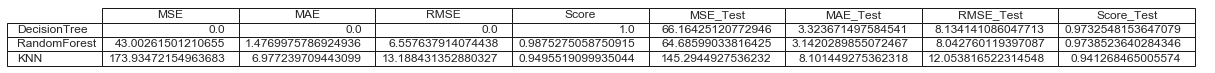

In [65]:
fig, ax = plt.subplots(figsize=(12, 1)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, metrics, loc='upper right', colWidths=[0.17]*len(metrics.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table
plt.savefig('metrics_table.png', transparent=True)

### 2.7.4) Visualization

In [66]:
y_pred_tree = tree_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_KNN = model.predict(X_test)

In [69]:
X_test.describe()

,totalLanguages,totalAmenities,serviceFee,reviewsCount,pictureCount,monthsSinceCreation,distToCenter,daysSinceUpdate,respTime,room,loc
count,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000
mean,2.434783,23.053140,63.420290,50.352657,23.946860,46.381159,14.408739,24.260870,2.864734,0.309179,6.937198
std,1.901545,9.002269,38.066143,56.597422,13.467043,24.890458,18.854793,57.338965,0.382966,0.503447,2.633046
min,0.000000,1.000000,0.000000,3.000000,5.000000,3.600000,0.132049,2.000000,1.000000,0.000000,0.000000
25%,0.000000,16.000000,45.000000,11.000000,15.000000,27.000000,1.357464,3.000000,3.000000,0.000000,6.000000
50%,3.000000,23.000000,62.000000,30.000000,21.000000,46.266667,5.882664,4.000000,3.000000,0.000000,6.000000
75%,4.000000,29.000000,77.000000,66.500000,30.000000,62.000000,22.891140,15.500000,3.000000,1.000000,6.500000
max,8.000000,51.000000,393.000000,352.000000,94.000000,99.033333,76.005778,400.000000,3.000000,2.000000,15.000000


In [145]:
rf_model
# save the model to disk
filename = r'C:\Miguel\Dropbox\Partilhas\model.sav'
pickle.dump(model, open(filename, 'wb'))

In [146]:
df_test=pd.DataFrame({'Actual':y_test, 'Predicted_Tree':y_pred_tree, 'Predicted_RF': y_pred_rf, 'Predicted_KNN': y_pred_KNN}) 
df_test.head(10)

,Actual,Predicted_Tree,Predicted_RF,Predicted_KNN
0,141.0,139.0,142.8,137.2
1,85.0,85.0,82.3,94.2
2,103.0,94.0,97.4,104.6
3,115.0,116.0,115.2,112.2
4,101.0,110.0,108.1,103.4
5,107.0,107.0,106.4,105.6
6,175.0,174.0,169.8,149.4
7,105.0,106.0,101.4,104.4
8,88.0,87.0,86.6,90.4
9,100.0,99.0,99.9,92.6


In [147]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 4 columns):
Actual            207 non-null float64
Predicted_Tree    207 non-null float64
Predicted_RF      207 non-null float64
Predicted_KNN     207 non-null float64
dtypes: float64(4)
memory usage: 6.5 KB


In [148]:
x1= list(range(0, 207))

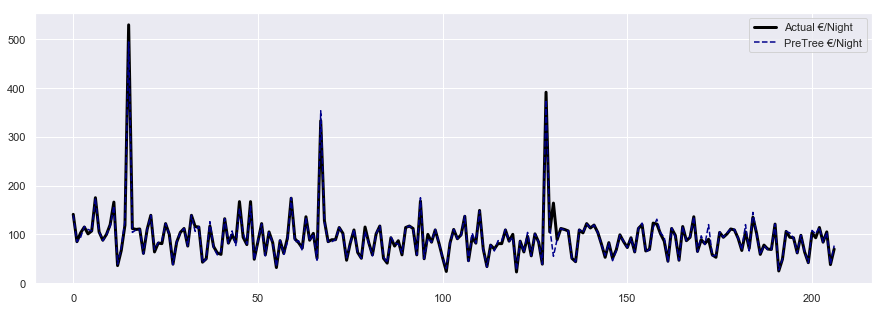

In [149]:
fig = plt.figure(figsize = (15,5))
plt.plot(x1, df_test['Actual'], label='Actual €/Night', color='black', linewidth=3)
plt.plot(x1, df_test['Predicted_Tree'], label='PreTree €/Night', color='darkblue', linestyle='--')
#plt.plot(x1, df_test['Predicted_RF'], label='PreRF €/Night', color='b', linestyle='--')
#plt.plot(x1, df_test['Predicted_KNN'],label='PreKNN €/Night', color='lightblue', linestyle='--')

plt.legend(loc='best')
plt.savefig("PredictionDecisionTree.png")
plt.show()

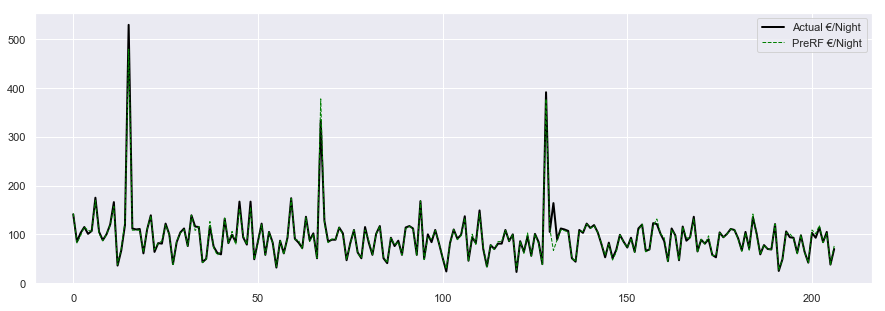

In [150]:
ig = plt.figure(figsize = (15,5))
plt.plot(x1, df_test['Actual'], label='Actual €/Night', color='black', linewidth=2)
#plt.plot(x1, df_test['Predicted_Tree'], label='PreTree €/Night', color='darkblue', linestyle='--')
plt.plot(x1, df_test['Predicted_RF'], label='PreRF €/Night', color='green', linestyle='--', linewidth=1)
#plt.plot(x1, df_test['Predicted_KNN'],label='PreKNN €/Night', color='lightblue', linestyle='--')

plt.legend(loc='best')
plt.savefig("PredictionRandomForest.png")
plt.show()

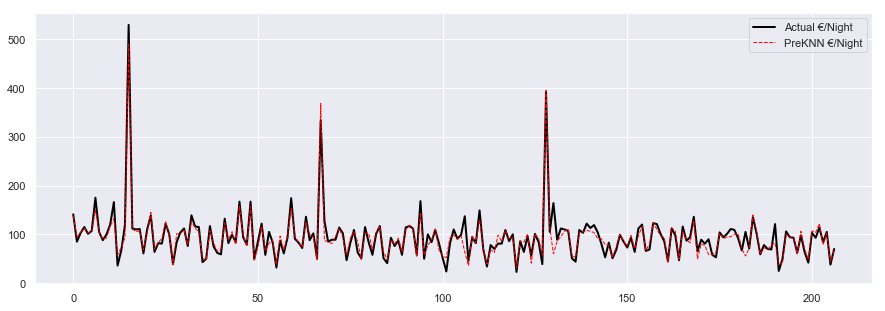

In [151]:
ig = plt.figure(figsize = (15,5))
plt.plot(x1, df_test['Actual'], label='Actual €/Night', color='black', linewidth=2)
#plt.plot(x1, df_test['Predicted_Tree'], label='PreTree €/Night', color='darkblue', linestyle='--')
#plt.plot(x1, df_test['Predicted_RF'], label='PreRF €/Night', color='b', linestyle='--')
plt.plot(x1, df_test['Predicted_KNN'],label='PreKNN €/Night', color='red', linestyle='--', linewidth=1)

plt.legend(loc='best')
plt.savefig("PredictionK-Nearest Neighbor.png")
plt.show()

KNN better in extreme values, RF better on average values

# __CONCLUSION__:

The best model to predict the €/Night, given the features analysed is the Random Forest model. 
This model it was chosen since its ability to predict the average prices is better than the other models tested, and it presents better metric scores overall. 

In [152]:
X_new = 

SyntaxError: invalid syntax (<ipython-input-152-13df4e1153ae>, line 1)

In [154]:
room = [{'totalLanguages': 2, 'totalAmenities': 15, 'serviceFee': 20, 'reviewsCount': 0, 'pictureCount': 10,'monthsSinceCreation':0,'distToCenter':1,'daysSinceUpdate':1,'respTime':1,'room':2, 'loc':2}]
X_new = pd.DataFrame(room)

In [156]:
rf_model.predict(X_new)[0]

60.6